# The Sequential model is a linear stack of layers.

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 2s 33us/step


In [4]:
# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

In [7]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features
# print("Training set: {}".format(train_labels.shape)) 
# print("Testing set:  {}".format(test_labels.shape)) 

Training set: (404, 13)
Testing set:  (102, 13)


# Cleaning the data

Each one of these input data features is stored using a different scale.

Some feature are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. 

This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

# Key Point:
As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias?

In [8]:
print(train_data[0])  # Display sample features, notice they are different scales

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


In [11]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


In [12]:
print(train_labels[0:10])

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


# Normalize features

It's recommended to normalize features that use different scales and ranges.

For each feature, subtract the mean of the feature and divide by the standard deviation:


In [13]:
# Test data is *not* used when calculating the mean and std.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependant on the choice of units used in the input.

# Build the model

In [17]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


# Train the model
The model is trained for 500 epochs, and record the training and validation accuracy in the history object.

In [24]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Visualize the model's training progress using the stats stored in the history object. 

We want to use this data to determine how long to train before the model stops making progress.

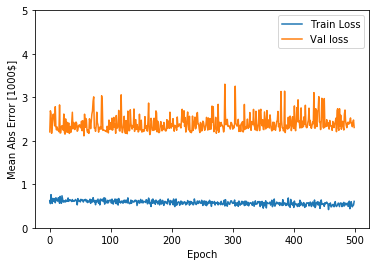

In [27]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),label = 'Val loss')
    plt.legend()
    plt.ylim([0,5])

plot_history(history)


....................................................................................................
..................................

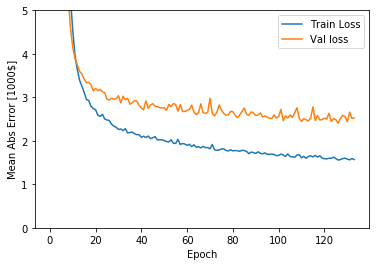

In [30]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)


In [31]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $3008.76


In [32]:
test_predictions = model.predict(test_data).flatten()

print(test_predictions)

[ 8.488895 18.209536 21.602999 33.810223 25.239447 20.688906 25.02393
 21.85143  19.122427 22.15771  20.697172 16.443068 16.007952 40.417744
 18.577433 19.014553 26.659222 18.26353  19.362938 26.650747 11.280443
 15.298573 20.749077 15.582104 17.48602  24.56782  29.726242 26.548042
 10.176087 19.753664 20.126143 15.183071 32.36955  25.036314 18.428442
  8.399824 15.382896 18.685564 20.547241 23.395048 29.027475 28.023642
 13.517678 41.084915 30.468525 24.65825  25.040487 17.442663 22.230364
 22.492218 32.805798 19.096254 10.61665  15.970621 33.093857 27.595312
 11.501356 46.73839  33.60516  22.929607 24.914217 15.485472 13.789377
 18.832754 22.877436 18.77656  12.677172 20.835474 15.452156  8.591387
 25.955143 27.362066 24.373049 15.066616 24.267962 18.137548 19.028677
 24.114397 33.052914  9.897543 21.034597 37.231167 14.520592 13.02251
 17.212889 18.502298 18.473475 19.867174 20.631205 31.226248 19.91823
 16.385643 24.97027  38.808533 34.39107  19.895401 35.055336 49.464226
 25.55137

# Conclusion

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).

Similarly, evaluation metrics used for regression differ from classification.

A common regression metric is Mean Absolute Error (MAE).

When input data features have values with different ranges, each feature should be scaled independently.

If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.

Early stopping is a useful technique to prevent overfitting.
